In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc #garbage collector
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,12)
%config Completer.use_jedi = False #fix TAB slowness with big frames

### Load and prepare various datasets

In [2]:
# --- Anagrafica Comuni

path_comuni = '../pac_agenziaentrate/regioni_citta/comuni/archivio_comuni/ElencoComuniAttuali_20170918.csv.read'

comuniAnagrafica = pd.read_csv(path_comuni, sep=';')
comuniAnagrafica.set_index('Codice Istat', inplace=True)
comuniAnagrafica = comuniAnagrafica[~comuniAnagrafica.index.isnull()]
#print(sum(comuniAnagrafica.index.isnull()))
assert not any(comuniAnagrafica.index.duplicated()), 'Duplicate Istat codes'
convTable = pd.read_csv('../provToReg.csv', index_col='Sigla automobilistica', dtype='str')
comuniAnagrafica = comuniAnagrafica.join(convTable, on='Sigla Provincia')
formattedValues = comuniAnagrafica.index.values.astype('int')
padZeros = np.vectorize(lambda x: str(x).rjust(6, '0'))
comuniAnagrafica['Codice Istat Lungo'] = (comuniAnagrafica['Codice regione'] + padZeros(formattedValues)).astype(int)

In [3]:
# --- Spese e redditi da OpenCivitas
speseERedditiComune = pd.read_csv('../opencivitas/data/opencivitas_spesa_storica_dati_irpef.csv') #dati per anno
convTable = pd.read_csv('../provToReg.csv', dtype='str', index_col='Sigla automobilistica')

speseERedditiComune = speseERedditiComune[~speseERedditiComune['Codice Istat Comune'].isna()]

speseERedditiComune = pd.merge(
    speseERedditiComune, 
    convTable, 
    how='left',
    left_on='Sigla Provincia_x', 
    right_index=True)

speseERedditiComune['Codice Istat Comune'].fillna(value=-1, inplace=True)


formattedValues = speseERedditiComune['Codice Istat Comune'].values.astype('int')

padZeros = np.vectorize(lambda x: str(x).rjust(6, '0'))
speseERedditiComune['Codice Istat Lungo'] = (speseERedditiComune['Codice regione'] + padZeros(formattedValues)).astype(int)

# --- Soggetti e luoghi da OpenCoesione
soggettiLuoghi = pd.read_csv('../pac_opencoesione/SoggettiELuoghi.csv')
soggettiLuoghi.drop(columns=['SOGG_COD_RUOLO', 'SOGG_PROGR_RUOLO'], inplace=True)
soggettiLuoghi = soggettiLuoghi[~soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.isna()]

/home/davide/anaconda3/envs/daf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,10,13,14,16,18,20,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Join OpenCoesione and OpenCivitas

In [5]:
speseERedditiComune.COMUNE_CAT_COD.isin(comuniAnagrafica['Codice Nazionale'].values).mean()
#speseERedditiComune.join(comuniAnagrafica['Codice Istat Lungo'])



0.98902585688514733

In [6]:
bEntePrivato = soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.str.startswith('1')

soggLuoghiPrivato = soggettiLuoghi[bEntePrivato]
#print(soggLuoghiPrivato.OC_CODICE_FISCALE_SOGG.isna().sum(), soggLuoghiPrivato.COD_COMUNE_SEDE_SOGG.isna().sum())

# luoghi (comuni) di sede soggetto che hanno ricevuto piu' fondi
fondiRicevuti = soggLuoghiPrivato.groupby('COD_COMUNE_SEDE_SOGG')['TOT_PAGAMENTI'].sum().sort_values(ascending=False).to_frame()
newData = fondiRicevuti.join(comuniAnagrafica.set_index('Codice Istat Lungo'))

newData = pd.merge(
    speseERedditiComune, 
    fondiRicevuti, 
    how='left',
    right_index = True,
    left_on='Codice Istat Lungo')


newData.TOT_PAGAMENTI.fillna(value=0, inplace=True)



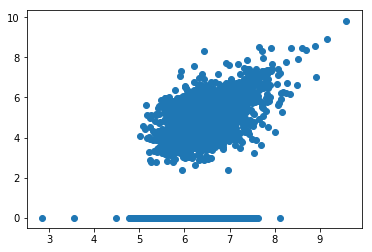

In [8]:
#newData.sort_values('TOT_PAGAMENTI', ascending=False)

ax = plt.scatter(np.log10(newData.SPESA_CCC_tot+1), np.log10(newData.TOT_PAGAMENTI+1))
plt.show()
